# MMAE 450 — HW04 Model Solution (Vectorized)
## 2D Transient Heat Conduction in a Plate (FTCS, Dirichlet BCs)

This notebook implements the required FTCS method for the 2D heat equation with Dirichlet boundary conditions on all four edges.

_Generated on 2026-02-15 17:19:56_


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Given data (from HW04 handout)
# -----------------------------
Lx = 1.0
Ly = 0.5
alpha = 1.0e-4
Nx = 51
Ny = 26

dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

print(f'dx = {dx:.6f} m')
print(f'dy = {dy:.6f} m')


dx = 0.020000 m
dy = 0.020000 m


In [2]:
# -----------------------------
# Stability condition (2D FTCS)
#   eta = alpha*dt*(1/dx^2 + 1/dy^2) <= 1/2
# -----------------------------
dt_max = 0.5 / (alpha * (1/dx**2 + 1/dy**2))
dt = 0.8 * dt_max  # safe choice

eta = alpha * dt * (1/dx**2 + 1/dy**2)
rx = alpha * dt / dx**2
ry = alpha * dt / dy**2

print(f'dt_max = {dt_max:.6e} s')
print(f'dt     = {dt:.6e} s')
print(f'eta    = {eta:.6f} (must be <= 0.5)')
print(f'rx = {rx:.6f}, ry = {ry:.6f}, rx+ry = {rx+ry:.6f}')


dt_max = 1.000000e+00 s
dt     = 8.000000e-01 s
eta    = 0.400000 (must be <= 0.5)
rx = 0.200000, ry = 0.200000, rx+ry = 0.400000


In [3]:
# -----------------------------
# Grid + initial condition
# -----------------------------
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Temperature array: T[i,j] ~ T(x_i, y_j)
T = np.zeros((Nx, Ny), dtype=float)

# Heated patch: 0.45<=x<=0.55 and 0.20<=y<=0.30 set to 100
patch_x = (x >= 0.45) & (x <= 0.55)
patch_y = (y >= 0.20) & (y <= 0.30)
T[np.ix_(patch_x, patch_y)] = 100.0

# Enforce Dirichlet BCs at t=0 (already 0, but do it explicitly)
T[0, :] = 0
T[-1, :] = 0
T[:, 0] = 0
T[:, -1] = 0

print('Initial Tmax =', np.max(T))


Initial Tmax = 100.0


In [4]:
# -----------------------------
# Time stepping setup
# -----------------------------
t_final = 200.0
Nt = int(np.ceil(t_final / dt))
t_final = Nt * dt  # actual simulated final time

# Required snapshot times
target_times = [0.0, 10.0, 50.0, 200.0]
target_steps = {t: int(np.round(t/dt)) for t in target_times}

print('Nt =', Nt)
print('Actual final time =', t_final)
print('Target snapshot steps:', target_steps)

# Histories
center_i = int(np.argmin(np.abs(x - 0.5)))
center_j = int(np.argmin(np.abs(y - 0.25)))

time = []
T_center_history = []
Tmax_history = []

# Snapshots dictionary
snapshots = {0.0: T.copy()}  # store t=0 snapshot

# Work array
T_new = T.copy()


Nt = 250
Actual final time = 200.0
Target snapshot steps: {0.0: 0, 10.0: 12, 50.0: 62, 200.0: 250}


In [5]:
# -----------------------------
# Vectorized FTCS time loop
# -----------------------------
for n in range(1, Nt+1):
    # interior update (vectorized)
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + rx * (T[2:, 1:-1] - 2.0*T[1:-1, 1:-1] + T[:-2, 1:-1])
        + ry * (T[1:-1, 2:] - 2.0*T[1:-1, 1:-1] + T[1:-1, :-2])
    )

    # Dirichlet BCs enforced every step
    T_new[0, :] = 0.0
    T_new[-1, :] = 0.0
    T_new[:, 0] = 0.0
    T_new[:, -1] = 0.0

    # swap
    T, T_new = T_new, T

    t = n * dt
    time.append(t)
    T_center_history.append(T[center_i, center_j])
    Tmax_history.append(float(np.max(T)))

    # store required snapshots (nearest-step approach)
    for t_target, n_target in target_steps.items():
        if n == n_target and (t_target not in snapshots):
            snapshots[t_target] = T.copy()

print('Stored snapshots at times:', sorted(snapshots.keys()))


Stored snapshots at times: [0.0, 10.0, 50.0, 200.0]


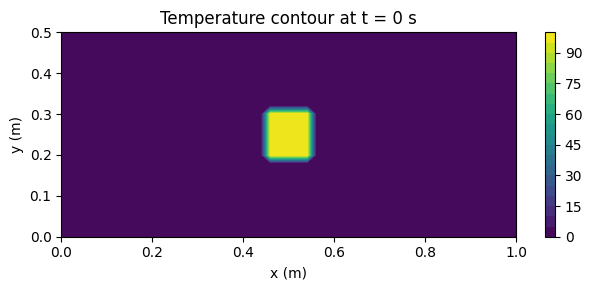

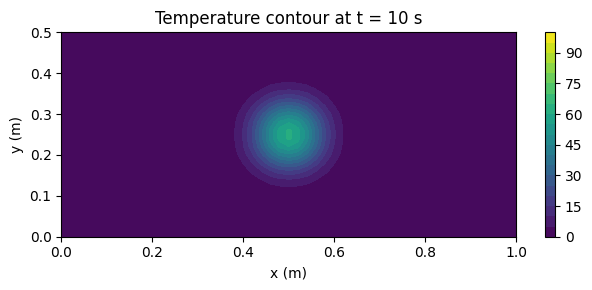

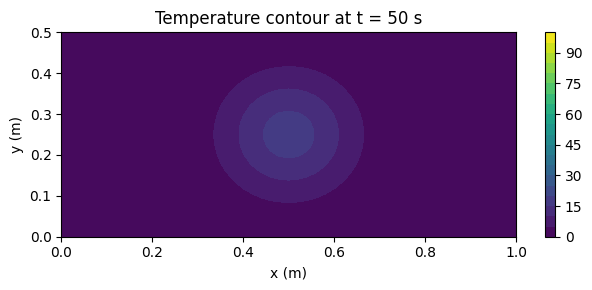

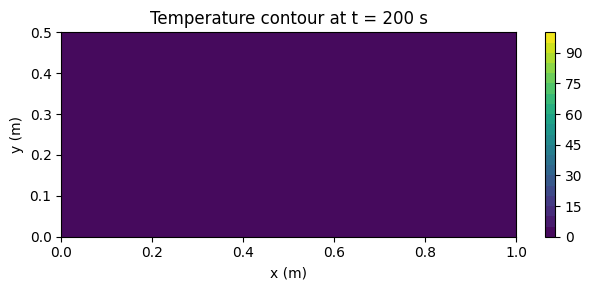

In [6]:
# -----------------------------
# Contour plots at t = {0, 10, 50, 200} s
# Use consistent color scale for visual comparison
# -----------------------------
X, Y = np.meshgrid(x, y, indexing='ij')

levels = np.linspace(0, 100, 21)  # consistent contour levels
vmin, vmax = 0, 100

for t_val in [0.0, 10.0, 50.0, 200.0]:
    T_snap = snapshots.get(t_val, None)
    if T_snap is None:
        print(f'WARNING: snapshot at t={t_val} not found')
        continue
    plt.figure(figsize=(6.5, 3.0))
    cf = plt.contourf(X, Y, T_snap, levels=levels, vmin=vmin, vmax=vmax)
    plt.colorbar(cf)
    plt.title(f'Temperature contour at t = {t_val:.0f} s')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.tight_layout()
    plt.show()


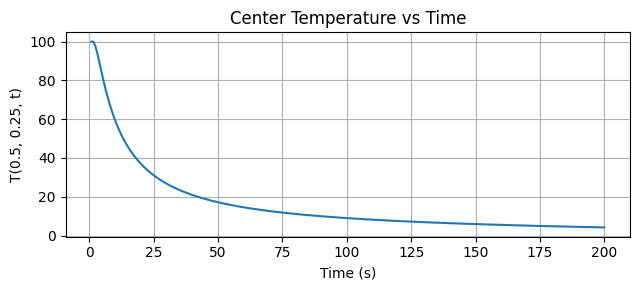

In [7]:
# -----------------------------
# Center-point temperature history
# -----------------------------
plt.figure(figsize=(6.5, 3.0))
plt.plot(time, T_center_history)
plt.xlabel('Time (s)')
plt.ylabel('T(0.5, 0.25, t)')
plt.title('Center Temperature vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()


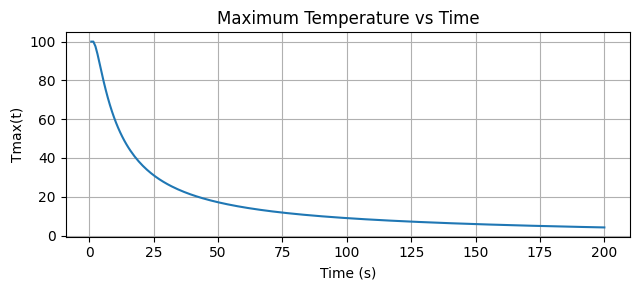

In [8]:
# -----------------------------
# Maximum temperature decay
# -----------------------------
plt.figure(figsize=(6.5, 3.0))
plt.plot(time, Tmax_history)
plt.xlabel('Time (s)')
plt.ylabel('Tmax(t)')
plt.title('Maximum Temperature vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# -----------------------------
# Cooling time metric: first time Tmax(t) < 10 C
# -----------------------------
t10 = None
for t_val, Tmax_val in zip(time, Tmax_history):
    if Tmax_val < 10.0:
        t10 = t_val
        break

print('t_10% (first time Tmax < 10 C) =', t10, 's')


t_10% (first time Tmax < 10 C) = 90.4 s
